In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint


from numpy import mean, std, dstack

from pandas import read_csv

from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal



%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20


/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/ten

### Check GPU support

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18199238915496701316
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4256364574164665178
physical_device_desc: "device: XLA_CPU device"
]


change current directory for access to dataset and signal analysis core

In [3]:
from os import chdir as cd
cd('..')

### Declare common display draphics functions


In [4]:
def display_block_of_values(dataframe=pd.DataFrame, x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(30,2)):
    assert isinstance(dataframe, pd.DataFrame)
    plt.figure(figsize=figsize)
    for index, col in enumerate(dataframe.columns):
        plt.subplot(plot_size[0],plot_size[1], index+1)
        plt.plot(dataframe[col])
        plt.title(col)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()


# 1) Mineral wool production dataset with synthetic anomalies

### Read dataset

In [4]:
from core.controller import SignalController
signals = SignalController(filepath="datasets/DATA/Nikol/L1_10-12.18.csv", )

Number of columns: 96
Number of columns after corr analysis: 52
Number of columns after clean: 41
NaN Values: False
Successfully scaled control_results
savgol filter smoothing successful


### display non smooth dataset 

In [ ]:
display_block_of_values(signals.scaled_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

### display savgol filter dataset 

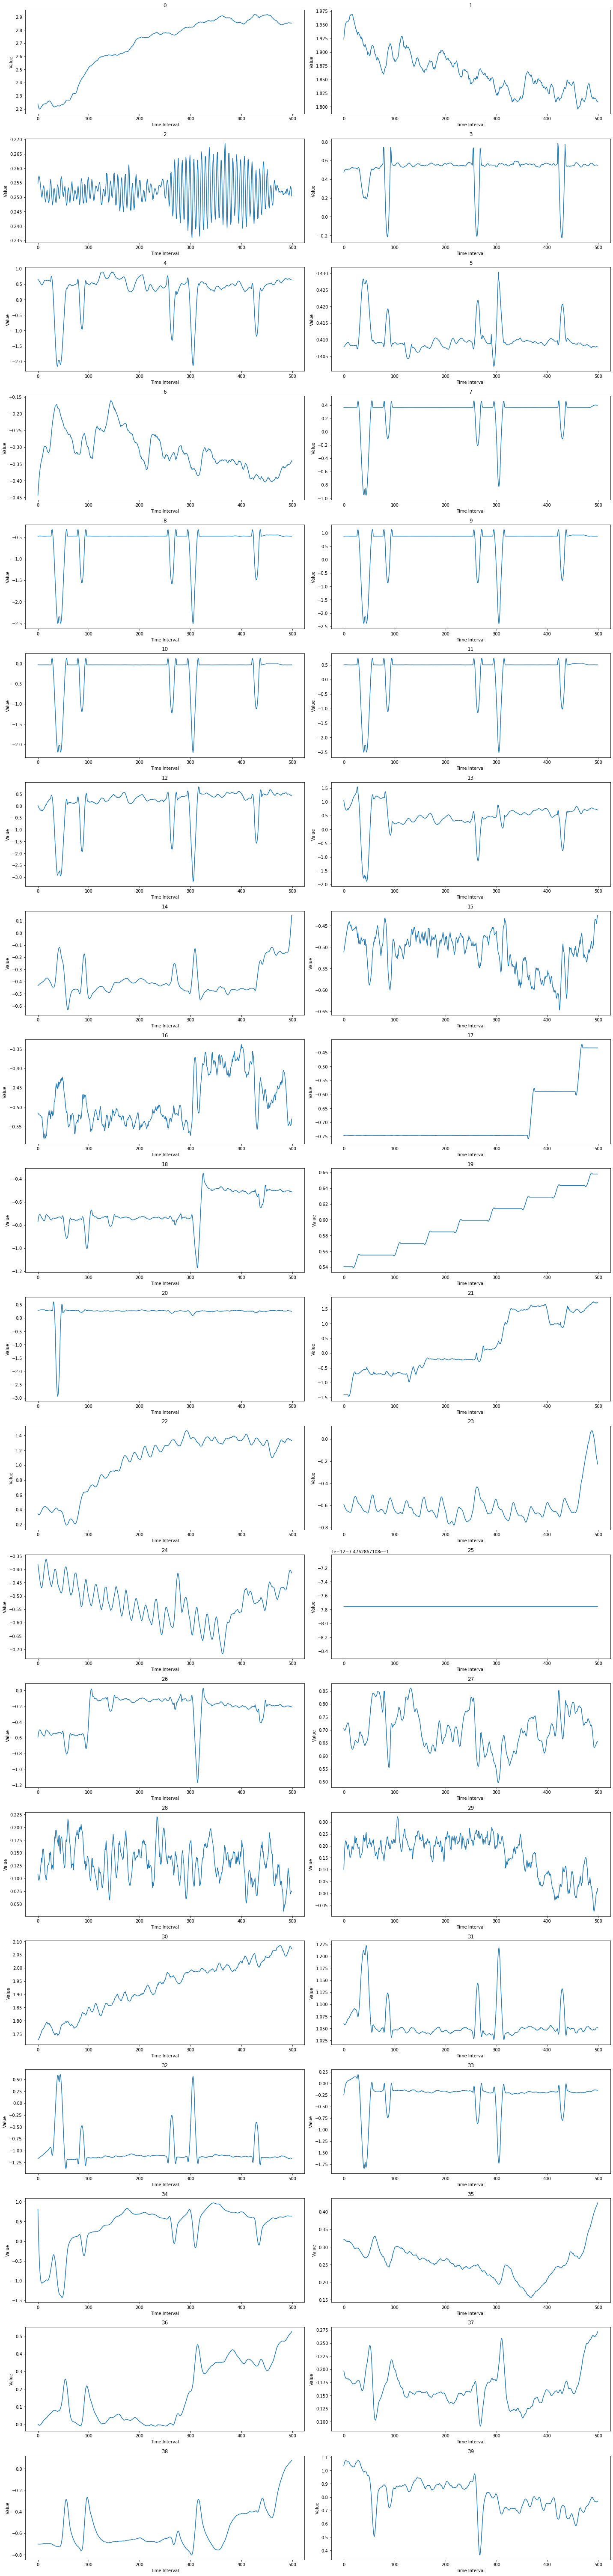

In [10]:
display_block_of_values(signals.smoothed_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

# Principal component analysis 2d and 3d

Объясненная вариация по основному компоненту: [9.96203154e-01 2.62617028e-03 7.39510135e-04]


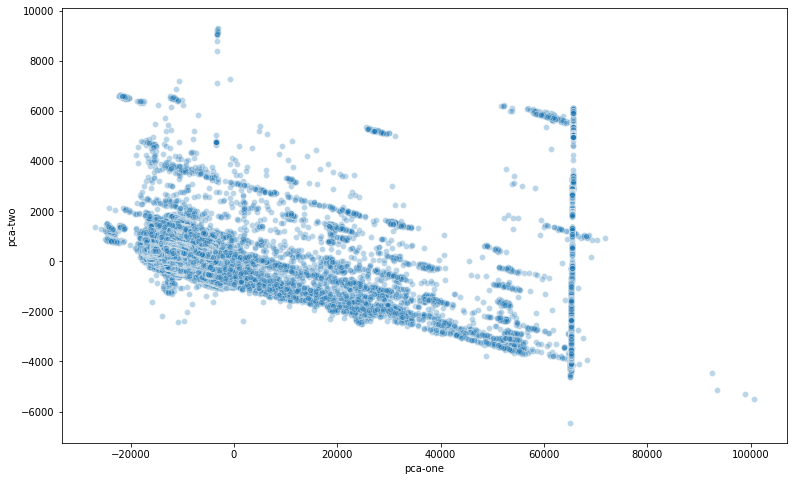

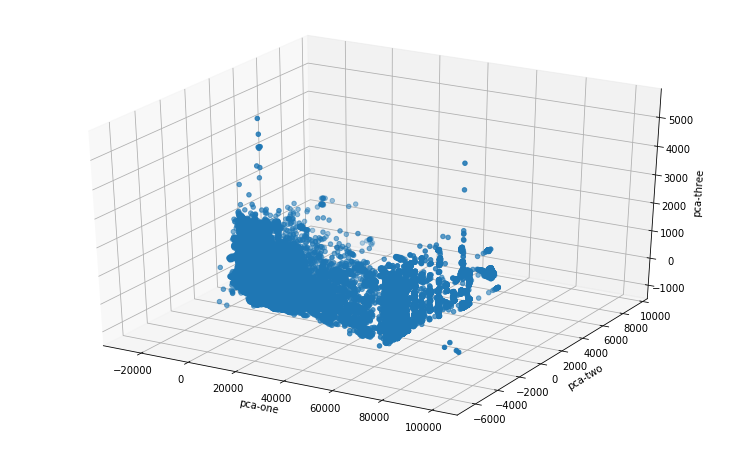

In [28]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(signals.control_results.values)

signals.control_results['pca-one'] = pca_result[:,0]
signals.control_results['pca-two'] = pca_result[:,1] 
signals.control_results['pca-three'] = pca_result[:,2]

print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))


plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=signals.control_results,
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=signals.control_results["pca-one"], 
    ys=signals.control_results["pca-two"], 
    zs=signals.control_results["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Display scaled data

In [10]:
signals.scaled_control_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132398 entries, 0 to 132397
Data columns (total 40 columns):
0     132398 non-null float64
1     132398 non-null float64
2     132398 non-null float64
3     132398 non-null float64
4     132398 non-null float64
5     132398 non-null float64
6     132398 non-null float64
7     132398 non-null float64
8     132398 non-null float64
9     132398 non-null float64
10    132398 non-null float64
11    132398 non-null float64
12    132398 non-null float64
13    132398 non-null float64
14    132398 non-null float64
15    132398 non-null float64
16    132398 non-null float64
17    132398 non-null float64
18    132398 non-null float64
19    132398 non-null float64
20    132398 non-null float64
21    132398 non-null float64
22    132398 non-null float64
23    132398 non-null float64
24    132398 non-null float64
25    132398 non-null float64
26    132398 non-null float64
27    132398 non-null float64
28    132398 non-null float64
29    132398 non-nu

### Clear data

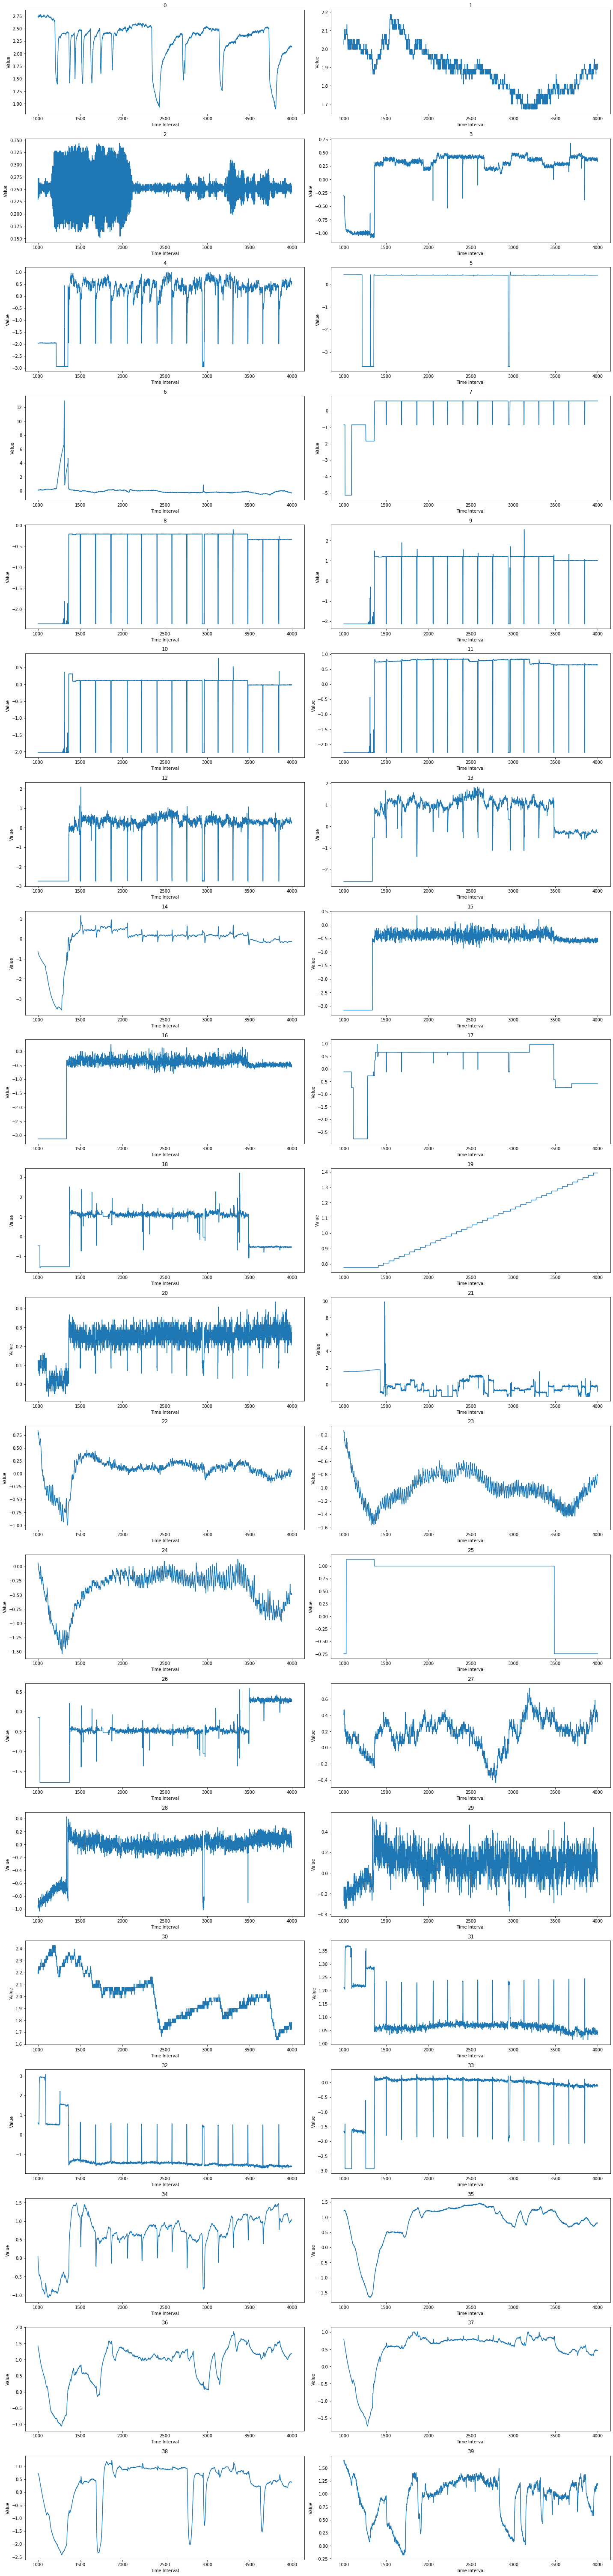

In [22]:
display_block_of_values(signals.scaled_control_results.iloc[1000:4000],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

### savgol filter data

In [ ]:
display_block_of_values(signals.scaled_savgol_filter_smoothing.iloc[:1000],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

На текущий момент имеем очищенный сигнал от выбросов, пустых значений, неинформативных признаков, представленный как: 
- Исходный сигнал 
- Нормированный исходный сигнал 
- Сглаженный с использованием savgol filter сигнал 
- Нормированный сглаженный с использованием savgol filter сигнал 
Тестирование алгоритмов и наложение сгенерированных аномалий будет производится на базе вышеуказанных наборов данных, остальные типы сглаживания будут добавляться позже

### Hypothesis about smoothing 

- Test different smoothing functions using one type for each sygnal   
- Test different smoothing functions using differents type for each sygnal or/and group of sygnals    

# Anomaly generation 

In [5]:
signals.smoothed_control_results.head()

0         1         2         3         4         5         6   \
0  2.237506  1.923655  0.254768  0.474581  0.652568  0.407851 -0.443597   
1  2.216951  1.935319  0.256701  0.489323  0.638199  0.407992 -0.419420   
2  2.204628  1.943786  0.257326  0.498924  0.616719  0.408178 -0.399012   
3  2.199181  1.949549  0.256915  0.504292  0.590622  0.408393 -0.381951   
4  2.199257  1.953100  0.255741  0.506341  0.562402  0.408617 -0.367814   

         7         8         9   ...        30        31        32        33  \
0  0.365078 -0.472837  0.877262  ...  1.726944  1.059932 -1.172624 -0.248912   
1  0.365014 -0.470468  0.879852  ...  1.729208  1.058076 -1.163343 -0.166393   
2  0.365001 -0.468877  0.881551  ...  1.732524  1.057584 -1.154580 -0.100356   
3  0.365028 -0.467954  0.882498  ...  1.736679  1.058218 -1.146242 -0.048925   
4  0.365086 -0.467590  0.882832  ...  1.741458  1.059741 -1.138234 -0.010221   

         34        35        36        37        38        39  
0  0.807711  0.321803  0.001642  0.196857 -0.701018  1.035483  
1  0.233061  0.320983 -0.002576  0.191402 -0.701399  1.054074  
2 -0.213775  0.320011 -0.004874  0.187366 -0.701624  1.066086  
3 -0.547880  0.318946 -0.005489  0.184548 -0.701700  1.072556  
4 -0.784334  0.317846 -0.004661  0.182750 -0.701632  1.074526  

[5 rows x 40 columns]

In [6]:
signal_samples = signals.get_sliced_signal
print(len(signal_samples))

3298


In [8]:
anomaly_signal_samples = signals.generate_anomalies(signal_samples)

(500, 40)


IndexError: index 40 is out of bounds for axis 1 with size 40

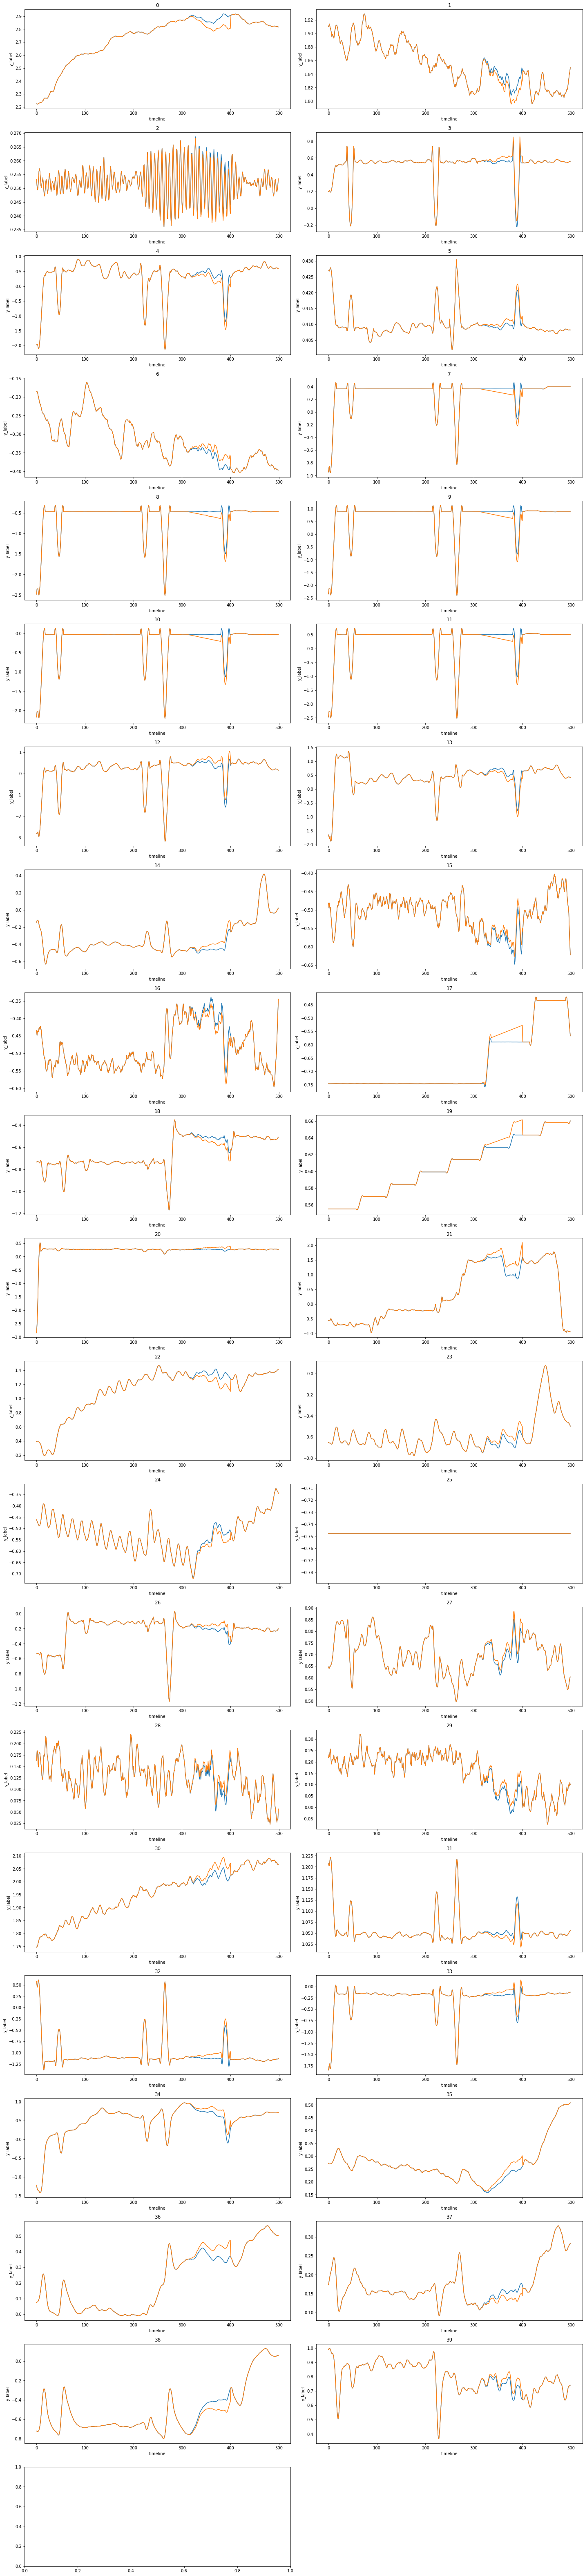

In [11]:
def display_signal_with_anomalies(samples , x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(15,3)):
    plt.figure(figsize=figsize)
    sample_number = 0
    print(samples.values.shape)
    for plot in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0],plot_size[1], plot+1)
        plt.plot(signal_samples[1].values[:,plot])
        plt.plot(anomaly_signal_samples[1].values[: , plot])
#         plt.plot(anomaly_signal_samples[1].condition_window)
        plt.title(plot)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        sample_number += 1

display_signal_with_anomalies(samples=anomaly_signal_samples[1],
                              x_label='timeline', 
                              y_label='y_label',
                              figsize=(20,100), 
                              plot_size=(24,2))

В данном примере имеем сгенерированные аномалии с первой степенью иннерционности (различная длинна), для одного сигнала.

In [11]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
#     axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Функция отображения историия обучения модели
def plot_model_history_2(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Convolutional Neural Network with categorical class definition

In [8]:
X_data = noise_generator.anomaly_signal_samples + noise_generator.signal_samples
shuffle(X_data)

X = np.array([signal.values for signal in X_data])
# Y = np.array([signal.condition_window for signal in X_data])
Y = np.array([int(signal.abnormal) for signal in X_data])

print(X.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.33, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape((Y_train.shape[0], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# trainY = Y
print(X_train.shape)
print(Y_train.shape)

# trainY = Y
print(X_test.shape)
print(Y_test.shape)

(6596, 500)
(6596,)
(4419, 500, 1)
(4419, 2)
(2177, 500, 1)
(2177, 2)


### Define model configuration

In [23]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 50, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return accuracy



### Fit categorical model

In [24]:
# run an experiment
def run_experiment(repeats=1):
    # load data
#     trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
#         score = evaluate_model(trainX, trainy, testX, testy)
        score = evaluate_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

Epoch 1/50
4419/4419 [==============================] - 3s 583us/step - loss: 0.8458 - accuracy: 0.5148
Epoch 2/50
4419/4419 [==============================] - 2s 536us/step - loss: 0.6893 - accuracy: 0.5451
Epoch 3/50
4419/4419 [==============================] - 2s 543us/step - loss: 0.6814 - accuracy: 0.5508
Epoch 4/50
4419/4419 [==============================] - 3s 578us/step - loss: 0.6763 - accuracy: 0.5632
Epoch 5/50
4419/4419 [==============================] - 2s 565us/step - loss: 0.6656 - accuracy: 0.5780
Epoch 6/50
4419/4419 [==============================] - 2s 550us/step - loss: 0.6613 - accuracy: 0.5920
Epoch 7/50
4419/4419 [==============================] - 3s 570us/step - loss: 0.6680 - accuracy: 0.5651
Epoch 8/50
4419/4419 [==============================] - 3s 580us/step - loss: 0.6663 - accuracy: 0.5513
Epoch 9/50
4419/4419 [==============================] - 2s 550us/step - loss: 0.6572 - accuracy: 0.5902
Epoch 10/50
4419/4419 [==============================] - 2s 545u

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1906857230029500582
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15966388092316376376
physical_device_desc: "device: XLA_CPU device"
]


# Convolutional Neural Network with flatten exit 

In [10]:
X_data = noise_generator.anomaly_signal_samples + noise_generator.signal_samples
shuffle(X_data)

X = np.array([signal.values for signal in X_data])
Y = np.array([signal.condition_window for signal in X_data])

print(X.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.33, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_train.shape[1], 1))

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# trainY = Y
print(X_train.shape)
print(Y_train.shape)

# trainY = Y
print(X_test.shape)
print(Y_test.shape)

(6596, 500)
(6596, 500)
(4419, 500, 1)
(4419, 500, 2)
(2177, 500, 1)
(2177, 500, 2)


### fit and evaluate a model

In [11]:
def evaluate_splitten_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0,70,64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
#     input_layer = Input(shape=(1024, 12))
    print(n_timesteps,n_features)
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
    flat1 = TimeDistributed(Flatten())(drop1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
    flat2 = TimeDistributed(Flatten())(drop2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu', padding='same')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
    flat3 = TimeDistributed(Flatten())(drop3)

    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    
    outputs = GRU(2, activation="softmax", return_sequences=True)(dense1)
#     outputs = Dense(n_outputs, activation='softmax')(dense1)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss="mse", optimizer="Adam",  metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return model, accuracy

In [ ]:

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# run an experiment
def run_splitten_experiment(repeats=1):
    scores = list()
    for r in range(repeats):
        model, score = evaluate_splitten_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model

# run the experiment
model_cont = run_splitten_experiment()

500 1


Epoch 1/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8253
Epoch 2/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 3/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 4/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 5/70
4419/4419 [==============================] - 16s 4ms/step - loss: nan - accuracy: 0.8285
Epoch 6/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 7/70
4419/4419 [==============================] - 16s 4ms/step - loss: nan - accuracy: 0.8285
Epoch 8/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 9/70
4419/4419 [==============================] - 15s 3ms/step - loss: nan - accuracy: 0.8285
Epoch 10/70
4419/4419 [==============================] - 15s 4ms/step - loss: nan - accuracy

In [13]:
model_cont.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 500, 64)      256         input_7[0][0]                    
____________________________________________________________________________________________

In [14]:
y_pred = model_cont.predict([X_test,X_test,X_test])
# print(y_pred)

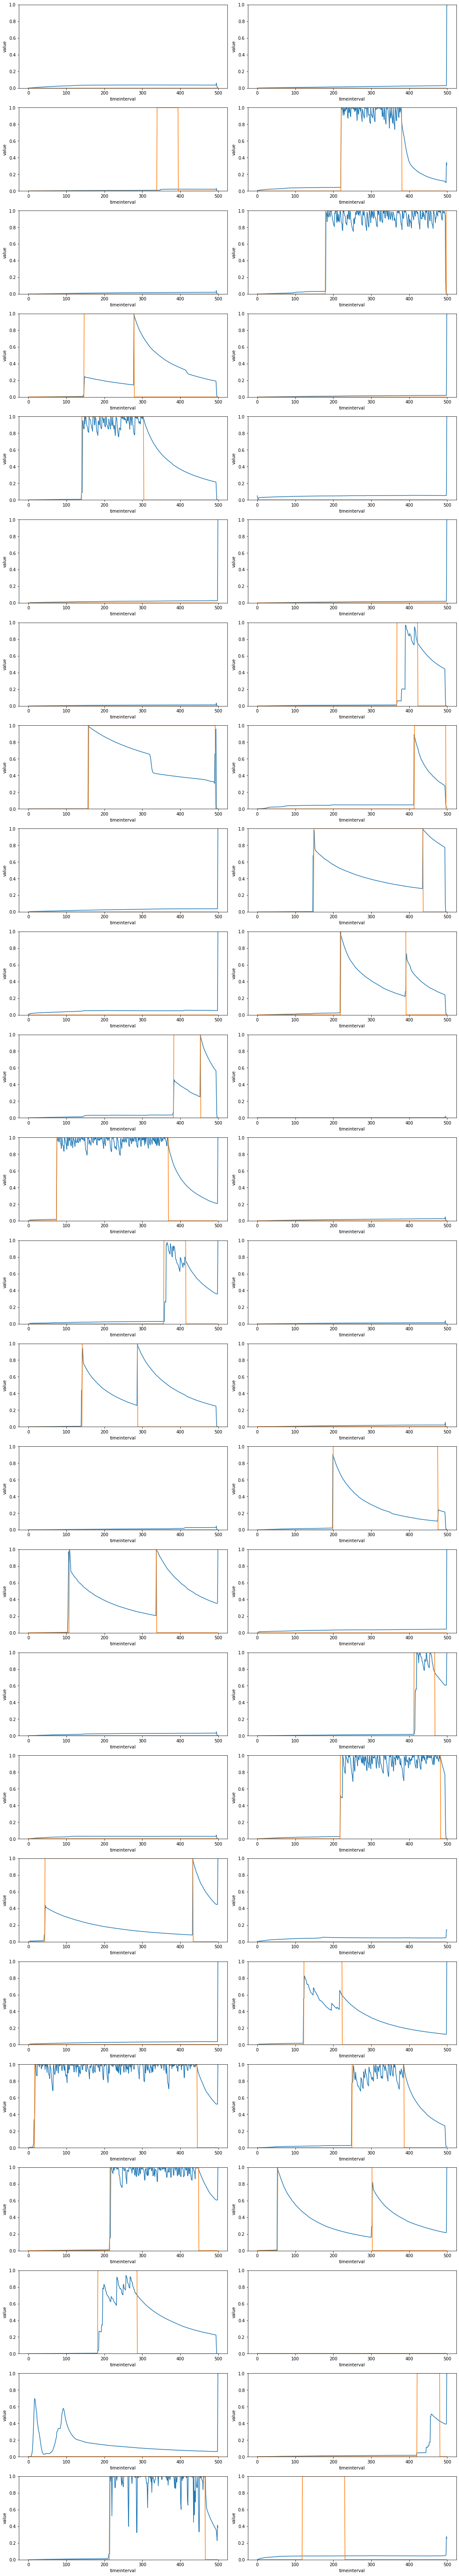

In [16]:
plt.figure(figsize=(15,100))
for index, sample in enumerate(Y_test[:50]):
    plt.subplot(30, 2, index+1)
    plt.ylim(0, 1)
    plt.plot(y_pred[index][:,1])
    plt.plot(Y_test[index][:,1])
    plt.xlabel('timeinterval')
    plt.ylabel('value')
    plt.tight_layout()

array([[2.4302575e-01, 1.5173150e-03],
       [9.5501518e-01, 2.4522038e-04],
       [5.5283928e-01, 3.7663770e-03],
       ...,
       [9.6503466e-01, 9.3975708e-05],
       [9.9033082e-01, 1.6952788e-04],
       [7.5387746e-01, 5.1136739e-03]], dtype=float32)

Имплементация результата будет производиться посредством кумулятивной оценки выхода нейронной сети 


In [347]:
# plt.figure(figsize=(30,15))
# plt.plot(Y_test[0])
# plt.plot(y_pred[0])
# plt.plot()
# plt.show()

In [15]:
model = Sequential()
input_layer = Input(shape=(500, 1))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2 = Conv1D(filters=64,
               kernel_size=4,
               strides=1,
               activation='relu', 
               padding='same')(conv1)
flatten_conv = TimeDistributed(Flatten())(conv2)
output_layer = GRU(2, activation="softmax", return_sequences=True)(flatten_conv)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss="binary_crossentropy", optimizer="Adam")



In [16]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.5082
Epoch 2/50
4419/4419 [==============================] - 25s 6ms/step - loss: 0.4620
Epoch 3/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4584
Epoch 4/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4579
Epoch 5/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4584
Epoch 6/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4567
Epoch 7/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4570
Epoch 8/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4554
Epoch 9/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4547
Epoch 10/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4535
Epoch 11/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4556
Epoch 12/50
4419/4419 [==============================] - 22s 5ms/step - lo

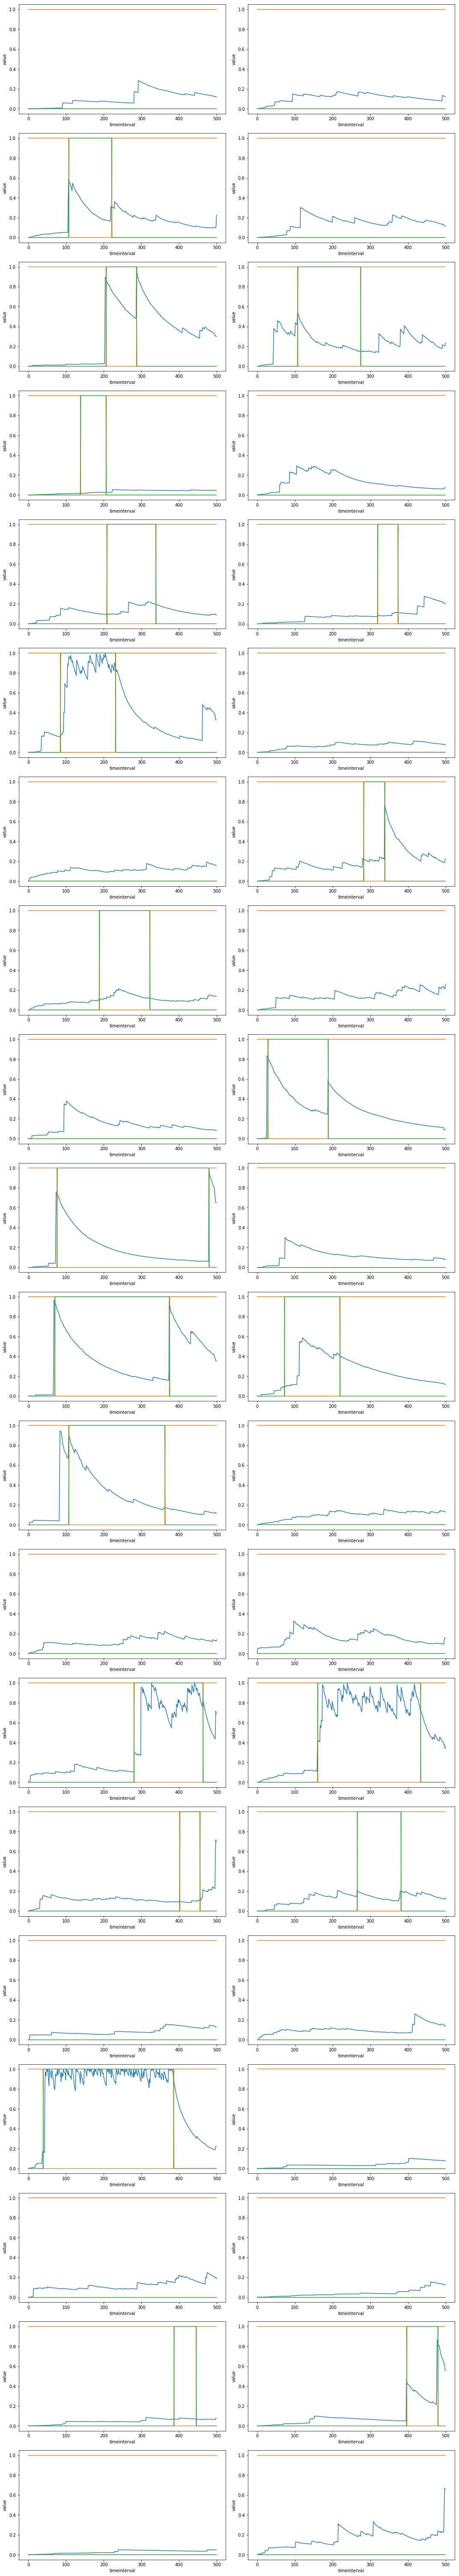

In [18]:
y_pred = model.predict(X_test)

plt.figure(figsize=(15,100))
for index, sample in enumerate(Y_test[:40]):
    plt.subplot(24, 2, index+1)
    plt.plot(y_pred[index][:,1])
    plt.plot(Y_test[index])
    plt.xlabel('timeinterval')
    plt.ylabel('value')
    plt.tight_layout()


# Conclusion

In [ ]:
kaspersky_set = pd.read_csv('datasets/attacks/attack_mode_0_type_21_id_246.csv', header=None)
for filename in os.listdir('datasets/attacks/')[1:]:
    data = pd.read_csv('datasets/attacks/' + filename, header=None)
    kaspersky_set = pd.concat([kaspersky_set,data])

In [33]:
kaspersky_set.to_csv('datasets/attacks/concate_attacks.csv')

False    552151
True      19557
Name: 55, dtype: int64

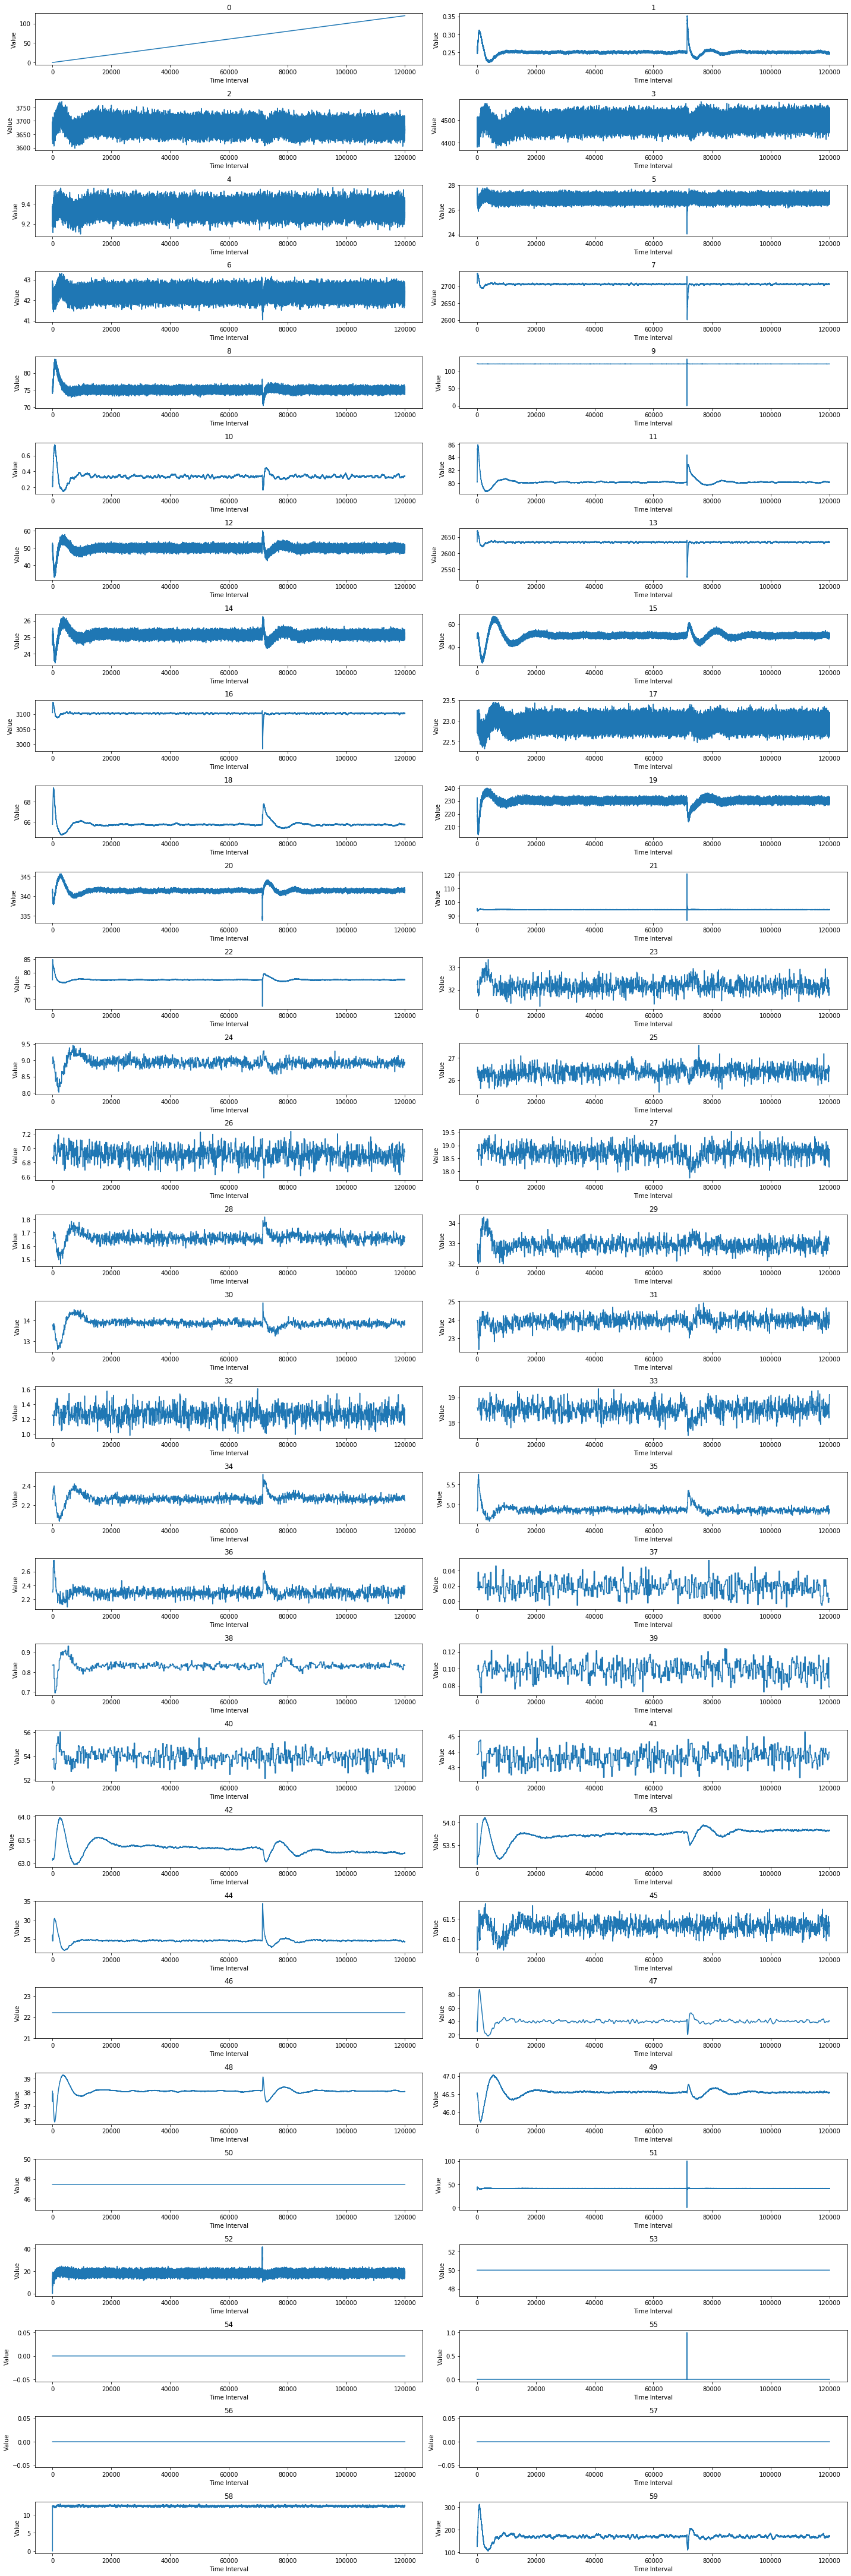

In [27]:
display_block_of_values(kaspersky_set,
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(50,2))

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))